In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
df = pd.read_csv('BTC-USD.csv')
print(df.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  


In [ ]:
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15))

3336   2023-11-05
3337   2023-11-06
3338   2023-11-07
3339   2023-11-08
3340   2023-11-09
3341   2023-11-10
3342   2023-11-11
3343   2023-11-12
3344   2023-11-13
3345   2023-11-14
3346   2023-11-15
3347   2023-11-16
3348   2023-11-17
3349   2023-11-18
3350   2023-11-19
Name: Date, dtype: datetime64[ns]


In [ ]:
cols = list(df)[1:6]

In [ ]:
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [ ]:
df_for_training = df[cols].astype(float)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
trainX = []
trainY = []


In [ ]:
n_future = 1
n_past=15

In [ ]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (3336, 15, 5).
trainY shape == (3336, 1).


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
188/188 [==============================] - 5s 11ms/step - loss: 0.0865 - val_loss: 0.0134
Epoch 2/5
188/188 [==============================] - 2s 12ms/step - loss: 0.0389 - val_loss: 0.0083
Epoch 3/5
188/188 [==============================] - 3s 14ms/step - loss: 0.0280 - val_loss: 0.0038
Epoch 4/5
188/188 [==============================] - 2s 12ms/step - loss: 0.0268 - val_loss: 0.0043
Epoch 5/5
188/188 [==============================] - 2s 13ms/step - loss: 0.0307 - val_loss: 0.0038


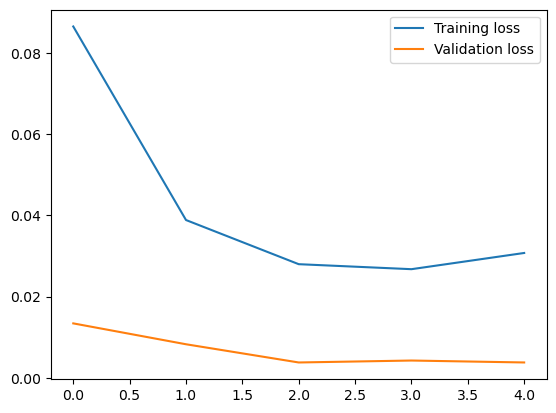

In [ ]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
prediction = model.predict(trainX[-n_days_for_prediction:])

1/1 [==============================] - 0s 350ms/step


In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [ ]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

C:\Users\sai\AppData\Local\Temp\ipykernel_11188\2126096244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

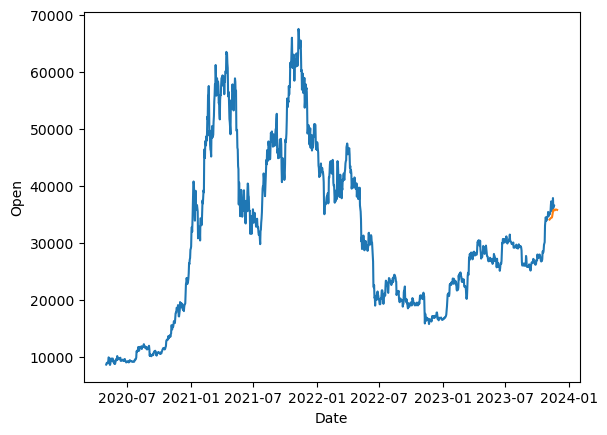

In [ ]:
sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

In [ ]:
y = []
x=[]
n_future = 1
n_past=15

In [ ]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    x.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [ ]:
x = np.array(x)[... , None]
y = np.array(y)[... , None]

In [ ]:
x_train=(x[:int(0.8 * x.shape[0])])
x_test=(x[int(0.8 * x.shape[0]):])
y_train=(y[:int(0.8 * y.shape[0])])
y_test=(y[int(0.8 * y.shape[0]):])

In [ ]:
print('trainX shape == {}.'.format(x_train.shape))
print('trainY shape == {}.'.format(y_train.shape))

trainX shape == (2668, 15, 5, 1).
trainY shape == (2668, 1, 1).


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 64)            17920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
151/151 [==============================] - 4s 12ms/step - loss: 0.0906 - val_loss: 0.1117
Epoch 2/5
151/151 [==============================] - 1s 10ms/step - loss: 0.0291 - val_loss: 0.0564
Epoch 3/5
151/151 [==============================] - 2s 13ms/step - loss: 0.0259 - val_loss: 0.4487
Epoch 4/5
151/151 [==============================] - 2s 14ms/step - loss: 0.0224 - val_loss: 0.0447
Epoch 5/5
151/151 [==============================] - 3s 17ms/step - loss: 0.0213 - val_loss: 0.0738


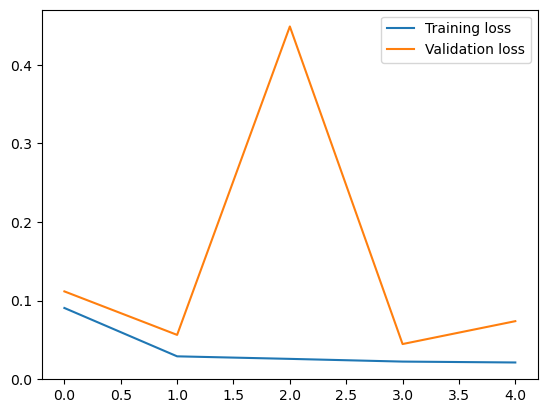

In [ ]:
history = model.fit(x_train, y_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
y_pred=model.predict(x_test[:])

21/21 [==============================] - 0s 4ms/step


In [ ]:
y_test=np.asarray(y_test)
print(type(y_test))
print(y_test.shape)
y_test.flat
y_pred=np.asarray(y_pred)
print(type(y_pred))
print(y_pred.shape)
y_pred.flat

<class 'numpy.ndarray'>
(668, 1, 1)
<class 'numpy.ndarray'>
(668, 1)


In [ ]:
(rmse, mae, r2) = eval_metrics(y_test.flat, y_pred.flat)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

  RMSE: 0.08858084414113064
  MAE: 0.059294192907734924
  R2: 0.9648119225399373


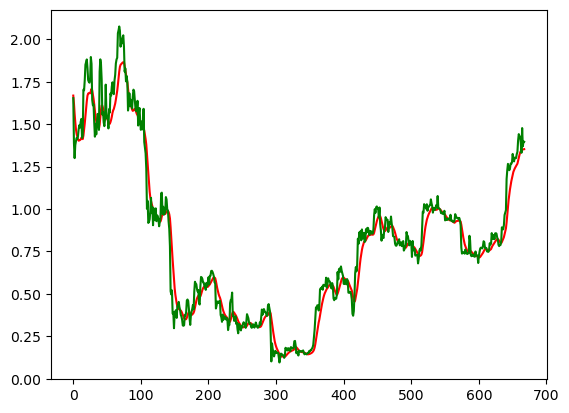

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred.squeeze() , color = "red" , label = "predicted")
plt.plot(y_test.squeeze() , color = "green" , label = "real")
plt.show()